# Introduction

In [1]:
filename = 'dataset_00_with_header.csv' #name of file
target_variable_name = 'y'

#The columns with missing percentage greater than this value will be dropped. range - (0,1)
missing_percentage = 0.75 

#size of the test dataset as a percentage
test_size = 0.3 

# 1. Load Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

from pyspark.sql import SparkSession
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import approxCountDistinct, countDistinct
from pyspark.sql.functions import count, when, isnan, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol
from pyspark.mllib.stat import Statistics

In [3]:
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv(filename, header=True, inferSchema=True, sep=',')
df.show()

+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+------+-----+-----+------+-----+----+----+----+----+----+----+----+----+----+----+----+------+------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----

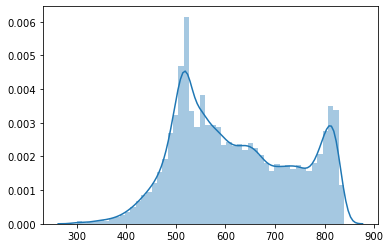

In [4]:
y = df.select(target_variable_name).toPandas()
sns.distplot(y)

In [5]:
from pyspark.sql.functions import approxCountDistinct, countDistinct

"""
Note: approxCountDistinct and countDistinct can be used interchangeably. Only difference is the computation time. 

"approxCountDistinct" is useful for large datasets 
"countDistinct" for small and medium datasets.

"""

def cardinality_calculation(df, cut_off=1):
    cardinality = df.select(*[countDistinct(c).alias(c) for c in df.columns])
    
    ## convert to pandas for efficient calculations
    final_cardinality_df = cardinality.toPandas().transpose()
    final_cardinality_df.reset_index(inplace=True) 
    final_cardinality_df.rename(columns={0:'Cardinality'}, inplace=True) 
    
    #select variables with cardinality of 1
    vars_selected = final_cardinality_df['index'][final_cardinality_df['Cardinality'] <= cut_off] 
    
    return final_cardinality_df, vars_selected

cardinality_df, cardinality_vars_selected = cardinality_calculation(df)

In [6]:
cardinality_vars_selected = list(cardinality_vars_selected)
cardinality_vars_selected

['x067', 'x094', 'x095', 'x096']

In [7]:
cardinality_vars_selected.extend(['x001'])

In [8]:
cardinality_vars_selected

['x067', 'x094', 'x095', 'x096', 'x001']

In [9]:
dropped_columns = [] #all dropped columns
dropped_columns.extend(cardinality_vars_selected) #appending to all dropped columns

In [10]:
df = df.drop(*cardinality_vars_selected)

In [11]:
#missing values check
# miss_percentage is set to 70% as discussed in the book
def missing_calculation(df, miss_percentage=0.70):
    
    #checks for both NaN and null values
    missing = df.select(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
    length_df = df.count()
    ## convert to pandas for efficient calculations
    final_missing_df = missing.toPandas().transpose()
    final_missing_df.reset_index(inplace=True) 
    final_missing_df.rename(columns={0:'missing_count'}, inplace=True) 
    final_missing_df['missing_percentage'] = final_missing_df['missing_count']/length_df
    
    #select variables with cardinality of 1
    vars_selected = final_missing_df['index'][final_missing_df['missing_percentage'] >= miss_percentage] 
    
    return final_missing_df, vars_selected

In [12]:
missing_df, missing_vars_selected = missing_calculation(df)

In [13]:
missing_df

,index,missing_count,missing_percentage
0,x002,21432,0.21432
1,x003,21432,0.21432
2,x004,21424,0.21424
3,x005,6110,0.06110
4,x006,0,0.00000
...,...,...,...
295,x301,0,0.00000
296,x302,73069,0.73069
297,x303,0,0.00000
298,x304,81875,0.81875


In [14]:
missing_vars_selected

92     x098
149    x155
236    x242
249    x255
250    x256
251    x257
253    x259
289    x295
296    x302
298    x304
Name: index, dtype: object

In [15]:
df = df.drop(*missing_vars_selected)

In [16]:
dropped_columns.extend(missing_vars_selected) #appending to all dropped columns

In [17]:
dropped_columns

['x067',
 'x094',
 'x095',
 'x096',
 'x001',
 'x098',
 'x155',
 'x242',
 'x255',
 'x256',
 'x257',
 'x259',
 'x295',
 'x302',
 'x304']

In [18]:
len(missing_df[missing_df['missing_percentage'] > 0])

41

# Using FICO scoring methodology, to categorize target variable

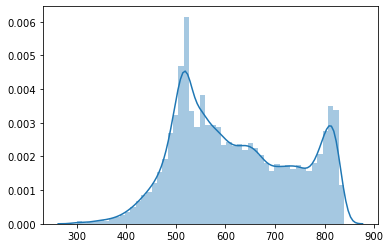

In [19]:
y = df.select(target_variable_name).toPandas()
sns.distplot(y)

<img src="Credit_Score_Ranges.png">

By comparing these cutoffs, to the target distribution seen above, I see that each of the categories are indeed differentiated in the distribution. 

In [20]:
from pyspark.sql import functions as F

df = df.withColumn('new_y', F.when(F.col("y") <= 550, 0) \
                                               .when(F.col("y") <=649, 1) \
                                               .when(F.col("y") <=699, 2) \
                                               .when(F.col("y") <=749, 3) \
                                               .otherwise(4))

In [21]:
train, test = df.randomSplit([0.7, 0.3], seed=12345)

In [22]:
train = train.drop('y')
test = test.drop('y')

In [23]:
train = train.select(*(col(c).cast("double").alias(c) for c in train.columns))
test = test.select(*(col(c).cast("double").alias(c) for c in test.columns))

In [24]:
column_names = train.columns

In [25]:
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=column_names, outputCols=column_names)
Median_Imputer = imputer.setStrategy("median").fit(train)

train = Median_Imputer.transform(train)
test = Median_Imputer.transform(test)

In [30]:
from pyspark.ml.feature import StandardScaler

#assemble individual columns to one column - 'features'
def assemble_vectors(df, features_list, target_variable_name, scale='no'):
    stages = []
    #assemble vectors
    if scale == 'no':
        assembler = VectorAssembler(inputCols=features_list, outputCol='features')
        stages = [assembler]
    else:
        assembler = VectorAssembler(inputCols=features_list, outputCol='assembled_features')
        scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol='features')
        stages = [assembler, scaler]
    #select target + newly created 'features' column
    selectedCols = [target_variable_name, 'features']
    #use pipeline to process sequentially
    pipeline = Pipeline(stages=stages)
    #assembler model
    assembleModel = pipeline.fit(df)
    #apply assembler model on data
    df = assembleModel.transform(df).select(selectedCols)

    return df

In [31]:
#exclude target variable and select all other feature vectors
features_list = train.columns
#features_list = char_vars #this option is used only for ChiSqselector
features_list.remove('new_y')

In [32]:
# apply the function on our dataframe
assembled_train = assemble_vectors(train, features_list, 'new_y')

In [33]:
for k, v in assembled_train.schema["features"].metadata["ml_attr"]["attrs"].items():
    features_df = pd.DataFrame(v)

In [34]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol='features', labelCol='new_y')
dt_model = dt.fit(assembled_train)

In [35]:
dt_output = dt_model.featureImportances
features_df['Decision Tree'] = features_df['idx'].apply(lambda x: dt_output[x] if x in dt_output.indices else 0)

In [36]:
from pyspark.ml.classification import RandomForestClassifier

rf  = RandomForestClassifier(featuresCol='features', labelCol='new_y')
rf_model = rf.fit(assembled_train)

In [37]:
rf_output = rf_model.featureImportances
features_df['Random Forest'] = features_df['idx'].apply(lambda x: rf_output[x] if x in rf_output.indices else 0)

In [38]:
features_df.drop('idx', axis=1, inplace=True)

In [39]:
num_top_features = 30
columns = ['Decision Tree', 'Random Forest']
score_table = pd.DataFrame({},[])
score_table['name'] = features_df['name']
for i in columns:
    score_table[i] = features_df['name'].isin(list(features_df.nlargest(num_top_features,i)['name'])).astype(int)

In [40]:
score_table['final_score'] = score_table.sum(axis=1)
score_table.sort_values('final_score',ascending=0)

,name,Decision Tree,Random Forest,final_score
92,x099,1,1,2
261,x274,1,1,2
268,x281,1,1,2
55,x057,1,1,2
53,x055,1,1,2
...,...,...,...,...
120,x127,0,0,0
121,x128,0,0,0
122,x129,0,0,0
123,x130,0,0,0


In [41]:
len(score_table[score_table['final_score'] > 0]['name'])

50

In [42]:
len(score_table[score_table['final_score'] > 1]['name'])

10

In [43]:
# Import the estimator and transformer class
from pyspark.ml import Transformer
# Parameter sharing class. We will use this for input column
from pyspark.ml.param.shared import HasInputCol
# Statistics class to calculate correlation
from pyspark.mllib.stat import Statistics
import pandas as pd

# custom class definition
class CustomCorrelation(Transformer, HasInputCol):
    """
    A custom function to calculate the correlation between two variables.
    
    Parameters:
    -----------
    inputCol: default value (None)
        Feature column name to be used for the correlation purpose. The input column should be assembled vector.
        
    correlation_type: 'pearson' or 'spearman'
    
    correlation_cutoff: float, default value (0.7), accepted values 0 to 1
        Columns more than the specified cutoff will be displayed in the shortlisted output dataframe. 
    """
    
    # Initialize parameters for the function
    def __init__(self, inputCol=None, correlation_type='pearson', correlation_cutoff=0.7):
        
        super(CustomCorrelation, self).__init__()
        
        assert inputCol, "Please provide a assembled feature column name"
        #self.inputCol is class parameter
        self.inputCol = inputCol 
        
        assert correlation_type == 'pearson' or correlation_type == 'spearman', "Please provide a valid option for correlation type. 'pearson' or 'spearman'. "
        #self.correlation_type is class parameter
        self.correlation_type = correlation_type
        
        assert 0.0 <= correlation_cutoff <= 1.0, "Provide a valid value for cutoff. Accepted range is 0 to 1" 
        #self.correlation_cutoff is class parameter
        self.correlation_cutoff = correlation_cutoff
            
    # Transformer function, method inside a class, '_transform' - protected parameter
    def _transform(self, df):
        
        for k, v in df.schema[self.inputCol].metadata["ml_attr"]["attrs"].items():
            features_df = pd.DataFrame(v)
            
        column_names = list(features_df['name'])
        df_vector = df.rdd.map(lambda x: x[self.inputCol].toArray())
        
        #self.correlation_type is class parameter
        matrix = Statistics.corr(df_vector, method=self.correlation_type)
        
        # apply pandas dataframe operation on the fit output
        corr_df = pd.DataFrame(matrix, columns=column_names, index=column_names)
        final_corr_df = pd.DataFrame(corr_df.abs().unstack().sort_values(kind='quicksort')).reset_index()
        final_corr_df.rename({'level_0': 'col1', 'level_1': 'col2', 0: 'correlation_value'}, axis=1, inplace=True)
        final_corr_df = final_corr_df[final_corr_df['col1'] != final_corr_df['col2']]

        #shortlisted dataframe based on custom cutoff
        shortlisted_corr_df = final_corr_df[final_corr_df['correlation_value'] > 0.7]
        temp_df = pd.DataFrame(np.sort(shortlisted_corr_df[['col1','col2']].values, axis=1), columns=['col1', 'col2'])
        shortlisted_corr_df.loc[:,'col1'] = list(temp_df['col1'])
        shortlisted_corr_df.loc[:,'col2'] = list(temp_df['col2'])
        shortlisted_corr_df = shortlisted_corr_df.drop_duplicates()
        return corr_df, shortlisted_corr_df

In [44]:
corr_clf = CustomCorrelation(inputCol='features')
output, shorlisted_output = corr_clf.transform(assembled_train)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [45]:
selected_atleastone = list(score_table[score_table['final_score'] > 0]['name'])
selected_atleasttwo = list(score_table[score_table['final_score'] > 1]['name'])

In [46]:
def correlation_based_removal(output, list_to_use):
    output1 = output.copy(deep=True)
    output1 = output1[output1.index.isin(list_to_use)]
    output1 = output1[list_to_use]
    final_corr_df = pd.DataFrame(output1.abs().unstack().sort_values(kind='quicksort')).reset_index()
    final_corr_df.rename({'level_0': 'col1', 'level_1': 'col2', 0: 'correlation_value'}, axis=1, inplace=True)
    final_corr_df = final_corr_df[final_corr_df['col1'] != final_corr_df['col2']]

    #shortlisted dataframe based on custom cutoff
    shortlisted_corr_df = final_corr_df[final_corr_df['correlation_value'] > 0.7]
    temp_df = pd.DataFrame(np.sort(shortlisted_corr_df[['col1','col2']].values, axis=1), columns=['col1', 'col2'])
    shortlisted_corr_df.loc[:,'col1'] = list(temp_df['col1'])
    shortlisted_corr_df.loc[:,'col2'] = list(temp_df['col2'])
    shortlisted_corr_df = shortlisted_corr_df.drop_duplicates()
    return shortlisted_corr_df

In [47]:
def which_is_greater(df):
    
    if df['RF1'] > df['RF2']:
        return df['col1']
    else:
        return df['col2']
    
def which_is_loser(df):
    
    if df['RF1'] < df['RF2']:
        return df['col1']
    else:
        return df['col2']

In [48]:
def append_rf_scores(shortlisted_corr_df, features_df):
    
    shortlisted_corr_df['RF1'] = shortlisted_corr_df['col1'].apply(lambda x: features_df[features_df['name'] == x]['Random Forest'].iloc[0])
    shortlisted_corr_df['RF2'] = shortlisted_corr_df['col2'].apply(lambda x: features_df[features_df['name'] == x]['Random Forest'].iloc[0])
    shortlisted_corr_df['winner'] = shortlisted_corr_df.apply(which_is_greater, axis=1)
    shortlisted_corr_df['loser'] = shortlisted_corr_df.apply(which_is_loser, axis=1)
    return shortlisted_corr_df

In [49]:
shortlisted_corr_df = correlation_based_removal(output, selected_atleastone)
shortlisted_corr_df = append_rf_scores(shortlisted_corr_df, features_df)

In [50]:
removal_list_vars = np.unique(list(shortlisted_corr_df['loser'])) #final list of features removed based on correlation

In [51]:
removal_list_vars

array(['x002', 'x003', 'x004', 'x007', 'x015', 'x042', 'x046', 'x057',
       'x059', 'x064', 'x099', 'x196', 'x226', 'x227', 'x236', 'x244',
       'x246', 'x273', 'x278'], dtype='<U4')

In [52]:
selected_atleastone = list(set(selected_atleastone).difference(set(removal_list_vars))) #uncorrelated vars
selected_atleasttwo = list(set(selected_atleasttwo).difference(set(removal_list_vars))) #uncorrelated vars

In [53]:
len(selected_atleastone), len(selected_atleasttwo)

(31, 8)

In [54]:
selected_atleastone

['x055',
 'x056',
 'x076',
 'x005',
 'x006',
 'x239',
 'x251',
 'x274',
 'x009',
 'x014',
 'x041',
 'x025',
 'x013',
 'x008',
 'x044',
 'x181',
 'x243',
 'x276',
 'x010',
 'x075',
 'x204',
 'x281',
 'x247',
 'x296',
 'x019',
 'x043',
 'x011',
 'x117',
 'x235',
 'x065',
 'x012']

In [55]:
selected_atleastone.extend([target_variable_name, 'new_y'])
df = df.select(selected_atleastone)
df.coalesce(1).write.mode('overwrite').option("header", "true").option("delimiter", ",").csv("categorical_subset_data.csv")

In [56]:
selected_atleastone.pop()

'new_y'

In [57]:
selected_atleastone.pop()

'y'

In [67]:
# apply the function on our dataframe
subset_train = assemble_vectors(train, selected_atleastone, 'new_y', scale='no')
subset_test = assemble_vectors(test, selected_atleastone, 'new_y', scale='no')

In [68]:
from pyspark.ml.classification import RandomForestClassifier

#fit rf model
rf  = RandomForestClassifier(featuresCol='features', labelCol='new_y')
rf_model = rf.fit(subset_train)

# make predictions
pred_train = rf_model.transform(subset_train).select(['new_y', 'prediction'])
pred_test = rf_model.transform(subset_test).select(['new_y', 'prediction'])

In [69]:
pred_train = pred_train.toPandas()
pred_test = pred_test.toPandas()

In [70]:
pred_train

,new_y,prediction
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
69873,4.0,4.0
69874,4.0,4.0
69875,4.0,4.0
69876,3.0,1.0


In [71]:
def make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test):
    
    list_values = ['550 & Below', '550 - 649', '650-699', '700-749', '750 & Above']
    plt.figure(1, figsize=(10,5))

    plt.subplot(121)
    sns.heatmap(cf_matrix_train, annot=True, yticklabels=list_values, 
                                xticklabels=list_values, fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,len(list_values)])
    plt.title('Train data')

    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, yticklabels=list_values, 
                                xticklabels=list_values, fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,len(list_values)])
    plt.tight_layout()
    plt.title('Test data')

    plt.tight_layout()
    return None

In [72]:
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix

cf_matrix_train = confusion_matrix(pred_train['new_y'], pred_train['prediction'])
cf_matrix_test = confusion_matrix(pred_test['new_y'], pred_test['prediction'])

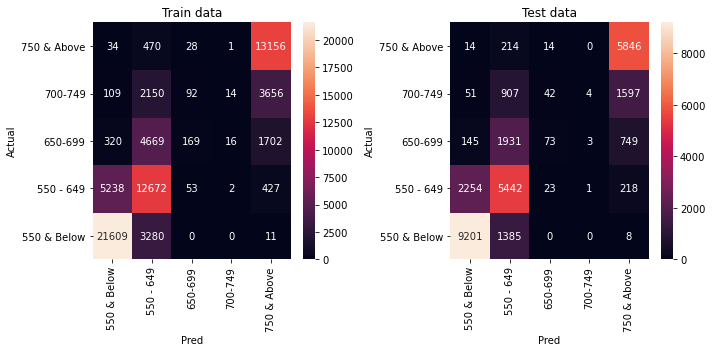

In [73]:
make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test)

In [75]:
accuracy_score(pred_train['new_y'], pred_train['prediction']), accuracy_score(pred_test['new_y'], pred_test['prediction'])

(0.6814734251123387, 0.6827567890578314)